# Sales Predictions
****

# Importing the Libraries
****

In [121]:
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from pmdarima.arima import auto_arima
import xgboost as xgb
from tensorflow import keras
import lightgbm as lgb
import itertools 
import calendar

# Get the data
****

## Importing The Data
****

## Data Format Converting
****

Changing the file type from csv to tsv (tab delimiter) and then back to csv because the decimal point separator isn't a dot but a comma.

In [14]:
X_train = pd.read_csv('X_train.tsv', delimiter='\t', decimal=",")
X_train.to_csv("X_train_csv.csv", sep=',', encoding='utf-8', quotechar='"', decimal='.')

X_test = pd.read_csv('X_test.tsv', delimiter='\t', decimal=",")
X_test.to_csv("X_test_csv.csv", sep=',', encoding='utf-8', quotechar='"', decimal='.')

y_train = pd.read_csv('y_train.tsv', delimiter='\t', decimal=",")
y_train.to_csv("y_train_csv.csv", sep=',', encoding='utf-8', quotechar='"', decimal='.')

y_test = pd.read_csv('y_test.tsv', delimiter='\t', decimal=",")
y_test.to_csv("y_test_csv.csv", sep=',', encoding='utf-8', quotechar='"', decimal='.')

# Looking Into The Data
****

In [ ]:
X_train.head()

In [ ]:
X_train.describe()

In [ ]:
X_train.dtypes

The key attribute presents the product, and the data type is categorical. Distinct products and their count:

In [ ]:
X_train["key"].value_counts()

Another way to get distinct values but easier to see all the values:

In [ ]:
np.unique(X_train["key"])

# Dealing with Missing Values
****

In [15]:
def missing_data_percentage(column):
    percentage = (X_train[column].isna().sum()/len(X_train[column])) * 100
    print('{} column - missing data percentage: {:.2f} %' .format(column, percentage))

In [16]:
for column in X_train.columns:
    missing_data_percentage(column)

key column - missing data percentage: 0.00 %
date column - missing data percentage: 0.00 %
x1 column - missing data percentage: 7.55 %
x2 column - missing data percentage: 7.63 %
x3 column - missing data percentage: 7.59 %
x4 column - missing data percentage: 7.61 %
x5 column - missing data percentage: 65.91 %
x6 column - missing data percentage: 65.56 %
x7 column - missing data percentage: 7.79 %
x8 column - missing data percentage: 7.79 %
x9 column - missing data percentage: 7.55 %
x10 column - missing data percentage: 7.70 %
x11 column - missing data percentage: 66.01 %
x12 column - missing data percentage: 7.53 %
x13 column - missing data percentage: 7.55 %
x14 column - missing data percentage: 7.53 %
x15 column - missing data percentage: 7.82 %
x16 column - missing data percentage: 7.61 %
x17 column - missing data percentage: 75.76 %
x18 column - missing data percentage: 65.83 %
x19 column - missing data percentage: 7.59 %
x20 column - missing data percentage: 7.61 %
x21 column - 

The columns with more than 50% of missing values will be removed from the dataset:

In [17]:
X_train.drop(['x5', 'x6', 'x11', 'x17', 'x18', 'x25', 'x32', 'x39', 'x46', 'x53', 'x60', 'x67', 'x74', 'x81', 'x95', 'x102' ], axis = 1, inplace=True)

In [18]:
X_train

,key,date,x1,x2,x3,x4,x7,x8,x9,x10,...,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112
0,683,01Jan2012,0.793085,0.000000,0.690346,0.000000,502.893893,10235.637780,1221.445737,3190.003651,...,0.053509,120.669814,0.955509,616.883023,200.144478,0.000000,20.391554,0.509713,216.851245,56.139906
1,683,01Feb2012,0.000000,0.000686,0.590133,0.000000,72.833160,88.793012,31.360328,2650.403762,...,112.074385,69.943189,2.704237,292.934714,138.241134,0.000000,15.316564,2.526962,39.451960,7.172635
2,683,01Mar2012,0.000000,0.000000,0.000000,0.672651,880.917406,553.998042,518.008231,2737.479632,...,0.998247,273.213135,0.000000,92.264811,100.972356,0.000000,12.774053,0.242973,35.226264,50.614383
3,683,01Apr2012,0.000000,0.000000,0.000000,0.022906,150.778812,11.951856,11.360498,3492.642102,...,182.047997,18.272077,-0.357520,5.272196,49.725924,0.000000,17.904427,29.437773,5.591309,0.000000
4,683,01May2012,0.000000,0.000000,0.000000,0.000000,5116.833341,114.048014,49.435797,2591.599732,...,15.836277,1629.479264,59.613338,0.060753,4.878556,0.000000,14.081303,0.125393,5.872891,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8432,99444,01Feb2018,0.000000,0.000000,0.000000,0.000000,60.744985,436.881447,319.466703,8466.054268,...,0.000000,1733.563294,-28.174332,1209.449129,632.966298,0.000000,110.422862,-3.137605,1168.589213,64.490601
8433,99444,01Mar2018,0.000000,0.000000,0.000000,0.000000,1659.203226,984.502872,583.706921,9052.754307,...,6.430861,1.393711,0.000000,735.371299,71.457377,0.131374,-67.789904,112.819870,541.409571,15.189098
8434,99444,01Apr2018,1.205455,0.000000,6.719704,0.000000,391.629990,835.051759,1054.700112,7938.102330,...,0.101345,56.857328,0.000000,210.508996,153.044792,0.433706,155.979550,1.532836,289.112965,1.863955
8435,99444,01May2018,0.000000,0.000000,NaN,0.000000,109.871651,3388.907606,1349.073196,9805.914396,...,0.304819,8.802166,0.000000,78.116811,17.687757,0.000000,-107.203368,8.136763,6.391709,6.154658


Dealing with missing data - using median value

In [19]:
def fill_na(column):
    X_train[column].fillna(X_train[column].median(), inplace=True)

In [20]:
for column in X_train.iloc[:,2:].columns:
    fill_na(column)
    missing_data_percentage(column)

x1 column - missing data percentage: 0.00 %
x2 column - missing data percentage: 0.00 %
x3 column - missing data percentage: 0.00 %
x4 column - missing data percentage: 0.00 %
x7 column - missing data percentage: 0.00 %
x8 column - missing data percentage: 0.00 %
x9 column - missing data percentage: 0.00 %
x10 column - missing data percentage: 0.00 %
x12 column - missing data percentage: 0.00 %
x13 column - missing data percentage: 0.00 %
x14 column - missing data percentage: 0.00 %
x15 column - missing data percentage: 0.00 %
x16 column - missing data percentage: 0.00 %
x19 column - missing data percentage: 0.00 %
x20 column - missing data percentage: 0.00 %
x21 column - missing data percentage: 0.00 %
x22 column - missing data percentage: 0.00 %
x23 column - missing data percentage: 0.00 %
x24 column - missing data percentage: 0.00 %
x26 column - missing data percentage: 0.00 %
x27 column - missing data percentage: 0.00 %
x28 column - missing data percentage: 0.00 %
x29 column - miss

Checking again if the attributes hold any missing values.

# Data Outliers
****

The interquartile range (IQR) is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles.
It is represented by the formula IQR = Q3 − Q1.
The lines of code below calculate and print the interquartile range for each of the variables in the dataset

In [21]:
columns = X_train.columns

Q1 = X_train[columns].quantile(0.25)
Q3 = X_train[columns].quantile(0.75)
IQR = Q3 - Q1

print(IQR)

key     57404.000000
x1          0.000000
x2          0.000000
x3          0.000000
x4          0.000000
            ...     
x108        0.000000
x109       38.167024
x110       15.743874
x111      190.101397
x112        4.255356
Length: 97, dtype: float64


Removing the outliers and calculating the skewness value again:

In [22]:
def transform_columns_flooring_capping(dataset, column):
    print("Skewness of column {} BEFORE the flooring and capping: {:.2f}".format(column, dataset[column].skew()))
    
    dataset[column] = np.where(dataset[column] < dataset[column].quantile(0.10), dataset[column].quantile(0.10), dataset[column])
    dataset[column] = np.where(dataset[column] > dataset[column].quantile(0.90), dataset[column].quantile(0.90), dataset[column])
    
    print("Skewness of column {} AFTER the flooring and capping: {:.2f}\n".format(column, dataset[column].skew()))
    return dataset[column]

In [23]:
for column in X_train.iloc[:,2:].columns:
    transform_columns_flooring_capping(X_train, column)

Skewness of column x1 BEFORE the flooring and capping: 14.83
Skewness of column x1 AFTER the flooring and capping: 2.07

Skewness of column x2 BEFORE the flooring and capping: 9.26
Skewness of column x2 AFTER the flooring and capping: 2.04

Skewness of column x3 BEFORE the flooring and capping: 5.59
Skewness of column x3 AFTER the flooring and capping: 2.07

Skewness of column x4 BEFORE the flooring and capping: 7.93
Skewness of column x4 AFTER the flooring and capping: 2.07

Skewness of column x7 BEFORE the flooring and capping: 6.23
Skewness of column x7 AFTER the flooring and capping: 1.81

Skewness of column x8 BEFORE the flooring and capping: 6.04
Skewness of column x8 AFTER the flooring and capping: 1.77

Skewness of column x9 BEFORE the flooring and capping: 7.25
Skewness of column x9 AFTER the flooring and capping: 1.74

Skewness of column x10 BEFORE the flooring and capping: 4.23
Skewness of column x10 AFTER the flooring and capping: 1.75

Skewness of column x12 BEFORE the flo

It is visible that removing the outliers below the 10th quantile and above 90th quantile results in better skewness of every column.

# Data Transformations
****

*Space for improvement: creating data transformers and calling them instead of the transformations above

Changing a date column from object into datetime type:

In [24]:
X_train['date'] = pd.to_datetime(X_train['date'])

Adding new month and year columns:

In [25]:
X_train["month"] = pd.DatetimeIndex(X_train["date"]).month
X_train["year"] = pd.DatetimeIndex(X_train["date"]).year

y_train["month"] = pd.DatetimeIndex(y_train["date"]).month
y_train["year"] = pd.DatetimeIndex(y_train["date"]).year

Changing numerical columns from object into datetime type, as well as other columns' types from object to float/int:

In [26]:
X_train.infer_objects()
X_train.dtypes

key               int64
date     datetime64[ns]
x1              float64
x2              float64
x3              float64
              ...      
x110            float64
x111            float64
x112            float64
month             int64
year              int64
Length: 100, dtype: object

In [27]:
y_train.infer_objects()
y_train.dtypes

key        int64
date      object
y        float64
month      int64
year       int64
dtype: object

# Attributes Correlation
****

Pearson’s correlation coefficient is the test statistics that measures the statistical relationship, or association, between two continuous variables.

When there are two independent variables that are very highly correlated, you definitely should remove one of them because you run into the multicollinearity conundrum and your regression model's coefficients related to the two highly correlated variables will be unreliable.

In [28]:
corr = X_train.corr()
corr

,key,x1,x2,x3,x4,x7,x8,x9,x10,x12,...,x105,x106,x107,x108,x109,x110,x111,x112,month,year
key,1.000000,0.009020,0.010855,-0.000696,-0.003560,0.012958,-0.007995,-0.002685,-0.033451,-0.006153,...,-0.013070,-0.006636,-0.009420,0.019460,-0.000734,0.004044,-0.005983,-0.008894,-0.000657,-0.001066
x1,0.009020,1.000000,-0.001504,0.002758,-0.004958,-0.002514,0.168715,0.184093,0.002808,0.441816,...,0.017767,0.008475,-0.002285,0.000192,0.010430,0.004062,0.008134,-0.006453,0.022850,-0.002896
x2,0.010855,-0.001504,1.000000,0.008258,0.019026,0.006475,-0.008417,-0.002371,0.001949,-0.010871,...,0.101134,0.002421,-0.008118,-0.002993,0.009667,0.005726,-0.003948,0.003573,-0.000734,0.018214
x3,-0.000696,0.002758,0.008258,1.000000,0.012233,0.010476,-0.009032,-0.010588,0.008027,-0.005360,...,-0.016126,-0.008118,0.009803,0.010984,0.012663,0.010429,0.001106,-0.004909,0.004193,-0.000368
x4,-0.003560,-0.004958,0.019026,0.012233,1.000000,0.010267,-0.023509,-0.020737,-0.003113,-0.006516,...,0.001690,-0.006962,-0.005505,-0.000878,-0.010438,-0.008539,0.001754,-0.008606,0.001023,0.011572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x110,0.004044,0.004062,0.005726,0.010429,-0.008539,0.021358,0.006825,0.009173,0.010593,-0.002485,...,-0.015692,0.386250,0.424457,0.421616,0.007151,1.000000,0.363990,0.293007,-0.002754,-0.007135
x111,-0.005983,0.008134,-0.003948,0.001106,0.001754,0.009555,-0.003607,0.007194,0.009450,-0.010532,...,-0.001358,0.806815,0.800378,0.149363,-0.002074,0.363990,1.000000,0.651730,-0.001209,-0.000560
x112,-0.008894,-0.006453,0.003573,-0.004909,-0.008606,0.008580,0.009550,0.017658,0.012812,0.000110,...,-0.000453,0.658148,0.643110,0.105122,-0.001024,0.293007,0.651730,1.000000,-0.000677,-0.002726
month,-0.000657,0.022850,-0.000734,0.004193,0.001023,0.005103,0.001335,0.000242,-0.005554,0.024554,...,0.006657,0.000798,-0.004181,-0.017083,-0.010068,-0.002754,-0.001209,-0.000677,1.000000,-0.122319


Here we are taking only the upper triangle of the correlation matrix to remove only one highly correlated attribute (and to look only positive correlation (Pearson's coefficient ranges from -1 to 1)).

Generally, if the correlation between a pair of variables is greater than 0.5-0.6, we should seriously consider dropping one of those variables.
We are selecting the columns which are having absolute correlation greater than 0.8 and making a list of those columns named 'to_drop'.

pearson's r = correlation coefficient = r:

0.00-0.19: very weak
0.20-0.39: weak
0.40-0.59: moderate 
0.60-0.79: strong
0.80-1.00: very strong

In [29]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))

<ipython-input-29-5563e36824c2>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))


In [30]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

['x9', 'x13', 'x16', 'x20', 'x23', 'x27', 'x30', 'x34', 'x37', 'x41', 'x44', 'x48', 'x55', 'x62', 'x65', 'x69', 'x72', 'x79', 'x83', 'x86', 'x88', 'x90', 'x93', 'x97', 'x100', 'x101', 'x104', 'x107', 'x111']


Using Pearson's Correlation Coefficient, there is a couple of  variables that are highly correlated (𝜌 > 0.75)

In [31]:
corr.loc["x88", "x101"]

0.9653448406738077

In [32]:
X_train = X_train.drop(to_drop, axis = 1)

In [33]:
len(X_train.columns)

71

## Explorative Data Analysis
****

Joining the datasets to visualize the sales for products and for other information in the X_train dataset):

In [34]:
dataset = X_train.append(y_train)
dataset = pd.merge(X_train, y_train, how = 'left', left_on = ["key", "month", "year"], right_on = ["key", "month", "year"])

Look into the scaled data:

Grouping data for EDA:

In [35]:
total_sales_monthly_mean = dataset.groupby(["month"], as_index = False)["y"].mean()
total_sales_monthly_sum = dataset.groupby(["month"], as_index = False)["y"].sum()

total_sales_yearly_mean = dataset.groupby(["year"], as_index = False)["y"].mean()
total_sales_yearly_sum = dataset.groupby(["year"], as_index = False)["y"].sum()

total_sales_daily_mean = dataset.groupby(["date_x"], as_index = False)["y"].mean()
total_sales_daily_sum = dataset.groupby(["date_x"], as_index = False)["y"].sum()

group_product_sales_mean = dataset.groupby(["key"], as_index=False)["y"].mean()
group_product_sales_sum = dataset.groupby(["key"], as_index=False)["y"].sum()

## Monthly Total Sales - Showing Seasonality
****

In [36]:
total_sales_monthly_mean.columns[0]

'month'

In [37]:
def plot_total_sales(measure):
    measure.plot(x = measure.columns[0], 
                 y = "y", 
                 figsize = (6, 4), 
                 title = "Sales - {}ly".format(measure.columns[0]), 
                 xlabel = measure.columns[0], 
                 ylabel = "Sales")

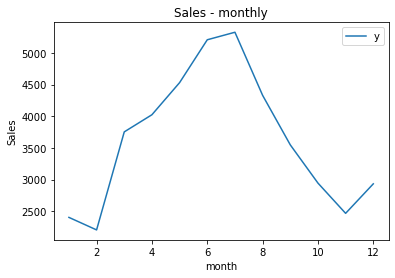

In [38]:
plot_total_sales(total_sales_monthly_mean)

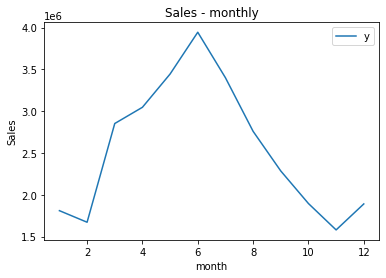

In [39]:
plot_total_sales(total_sales_monthly_sum)

There is an obvious "seasonality" (Eg: peak sales around a time of year) - it is visible that the cummulative total sales of the company peak in May and June, then drop in winter months

## Yearly Total Sales - Showing Trends
****

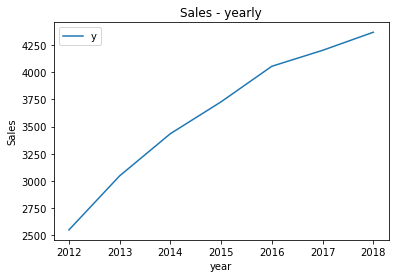

In [40]:
plot_total_sales(total_sales_yearly_mean)

*As we can see we have a trending increase of item sales count (mean) since 2012 to 2018

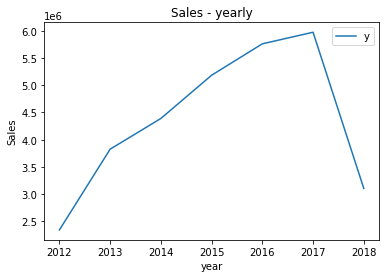

In [41]:
plot_total_sales(total_sales_yearly_sum)

There is a visible drop in sales since 2017

## Sales by Date
****

In [42]:
total_sales_daily_mean

,date_x,y
0,2012-01-01,1245.364114
1,2012-02-01,1559.680929
2,2012-03-01,3085.166393
3,2012-04-01,2703.845190
4,2012-05-01,3489.027823
...,...,...
73,2018-02-01,2544.695370
74,2018-03-01,4108.612587
75,2018-04-01,4605.923126
76,2018-05-01,5637.412732


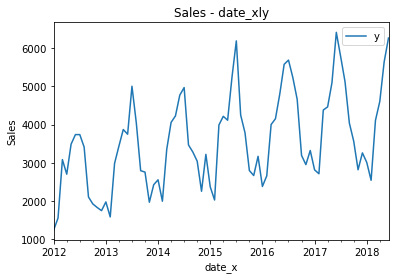

In [43]:
plot_total_sales(total_sales_daily_mean)

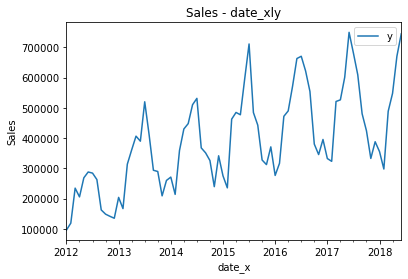

In [44]:
plot_total_sales(total_sales_daily_sum)

Growth in sales (mean sales and sum of sales) is clearly visible. Also, sales tend to peak in the summer months.

## Sales by Product
****

In [45]:
def plot_sales_by_product(dataset):
    axes = plt.subplots(1, 1, figsize=(45, 15), sharex=True)
    ax = sn.barplot(x="key", y="y", data=dataset, palette="rocket").set_title("Yearly mean")
    plt.xticks(rotation = 90)
    plt.show()

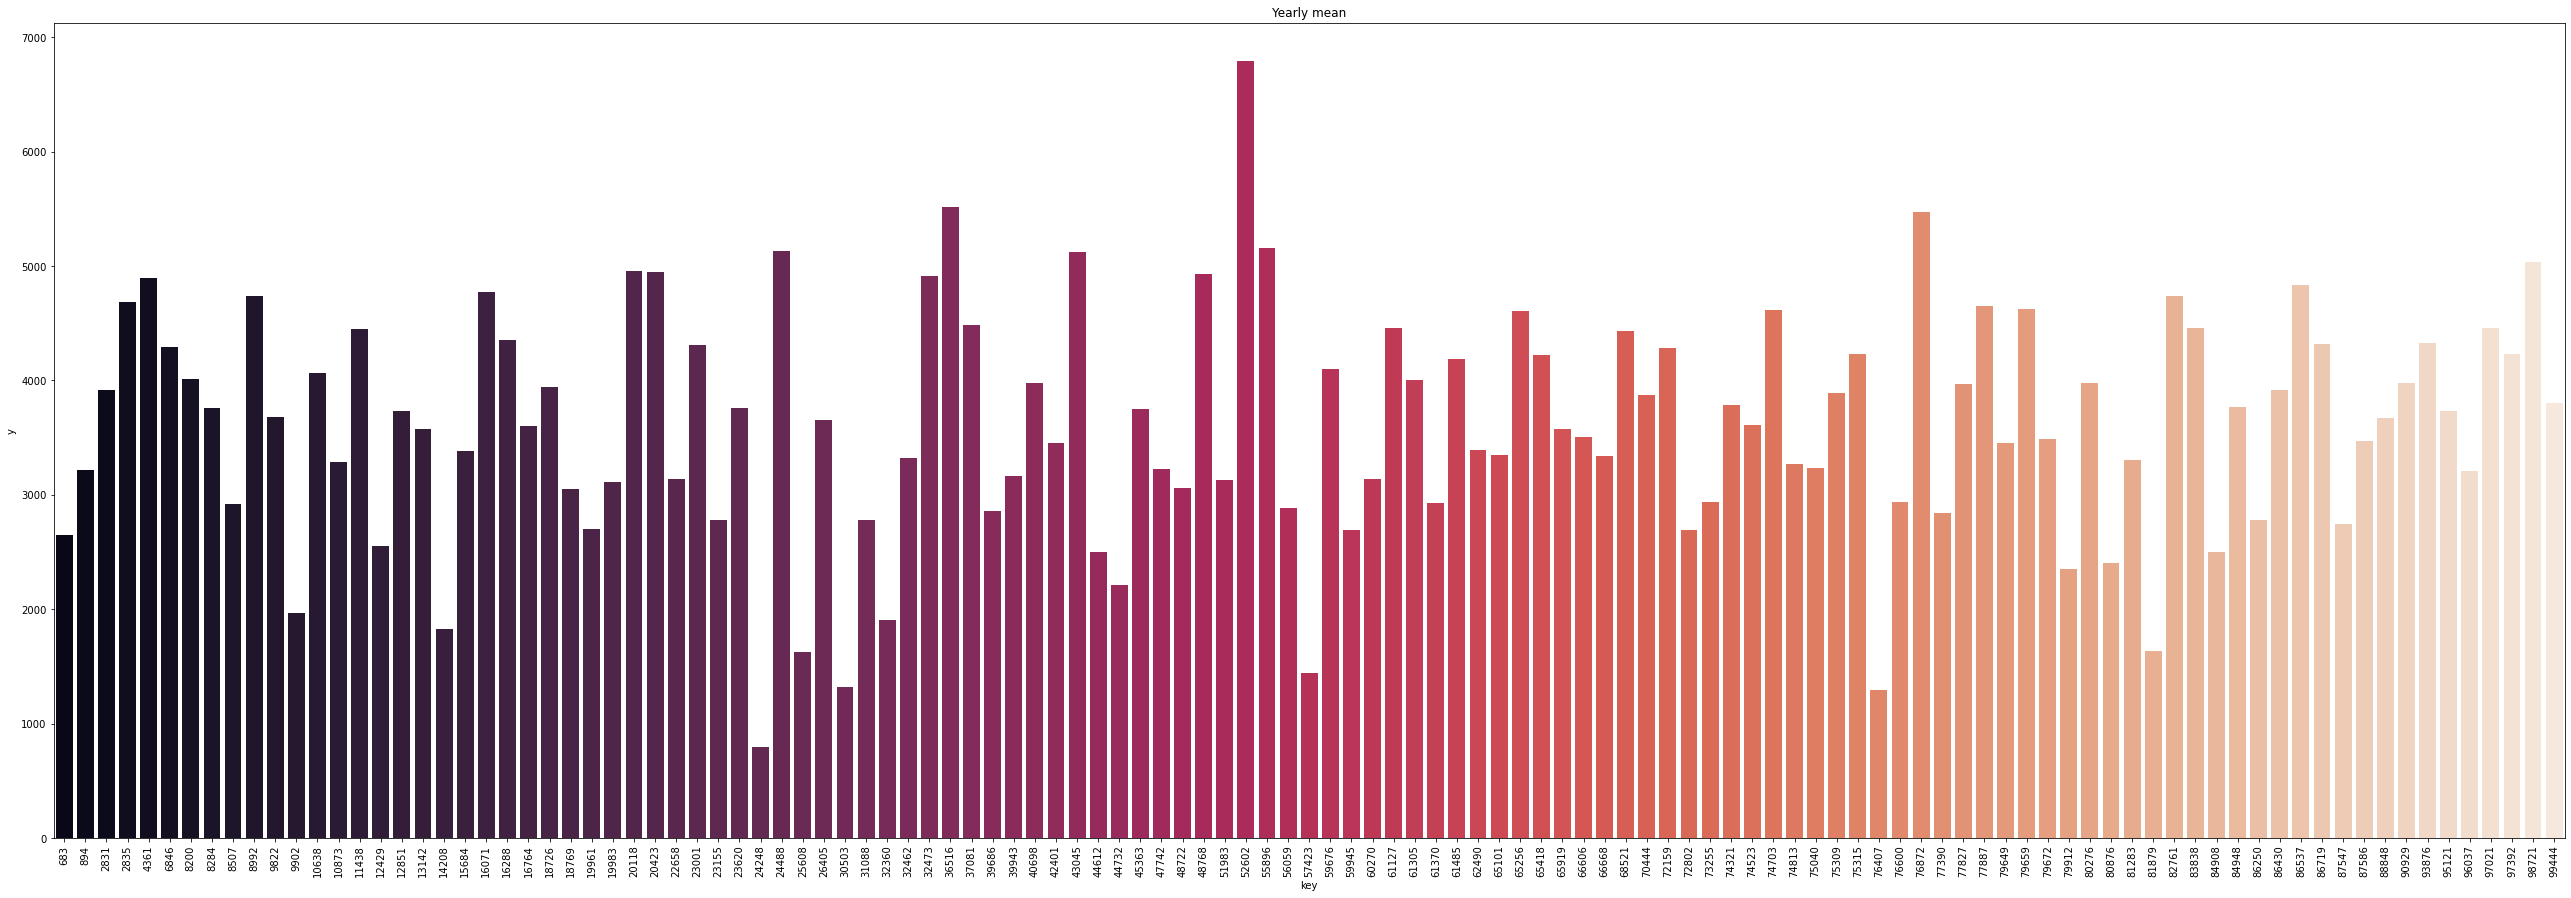

In [46]:
plot_sales_by_product(group_product_sales_mean)

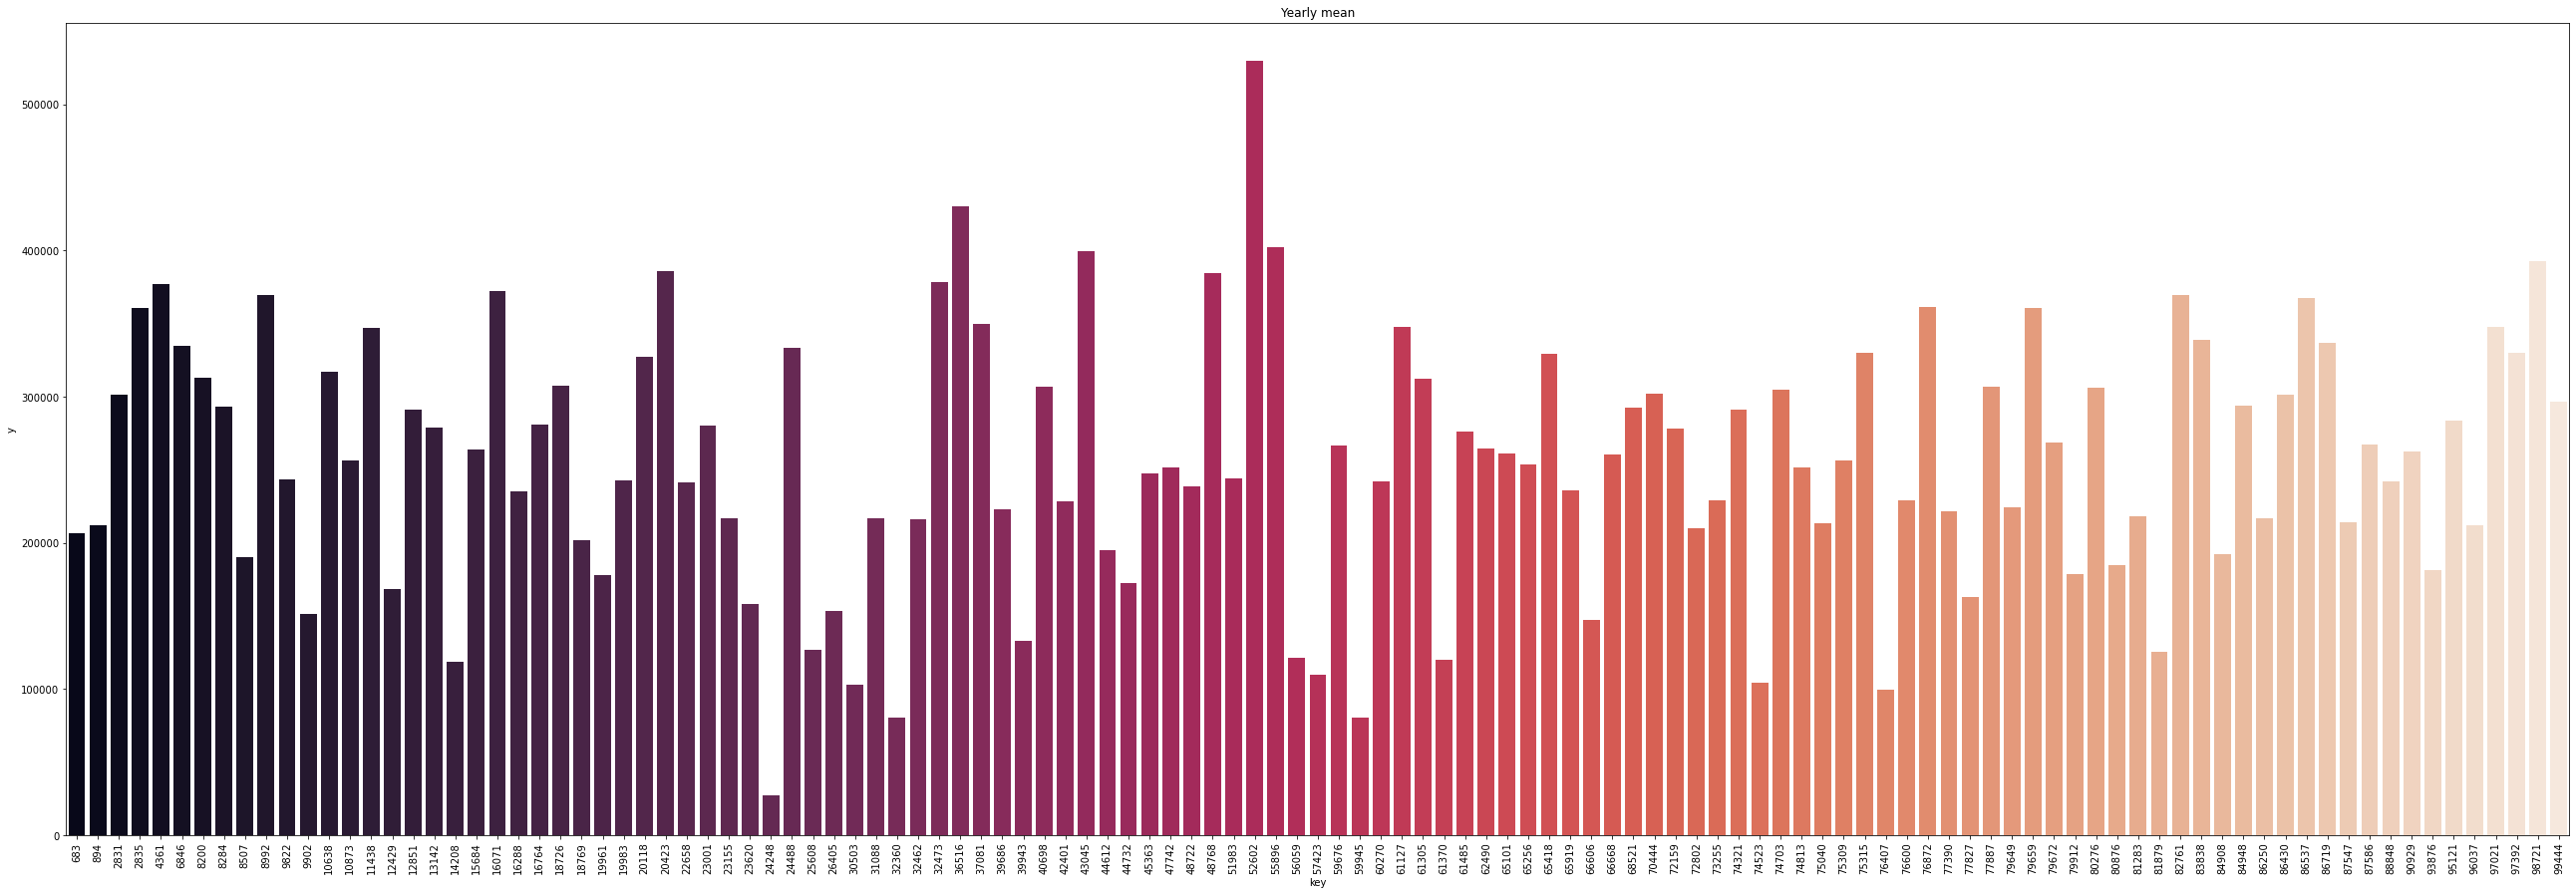

In [47]:
plot_sales_by_product(group_product_sales_sum)

It's visible that some of the products have much higher sales than the other. Let's see what are the top 10 products by mean and summed yearly sales:

In [48]:
group_product_sales_mean.nlargest(10, "y")

,key,y
56,52602,6788.668269
42,36516,5512.768687
88,76872,5469.976213
57,55896,5157.350431
34,24488,5130.673219
48,43045,5118.050320
117,98721,5038.642555
27,20118,4955.508885
28,20423,4950.929064
54,48768,4927.716751


In [49]:
group_product_sales_sum.nlargest(10, "y")

,key,y
56,52602,529516.124969
42,36516,429995.957601
57,55896,402273.333639
48,43045,399207.924981
117,98721,393014.119313
28,20423,386172.466955
54,48768,384361.906579
41,32473,378162.113425
4,4361,376849.859478
20,16071,372146.150452


This way it can be seen that the sum of products sold and the median value show different products.

*Space for improvement: Let's see which products had sales growth in the last 6 and 12 months, and which had a decrease in sales, and find the product with biggest growth and with biggest fall

# Seasonal Decomposition Using Moving Averages
****

In [50]:
dataset["y"].fillna(dataset["y"].median(), inplace=True)

Additive Model

An additive model suggests that the components are added together as follows:

y(t) = Level + Trend + Seasonality + Noise
An additive model is linear where changes over time are consistently made by the same amount.

In [51]:
dataset = dataset.set_index('date_x')
dataset.index

DatetimeIndex(['2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01',
               ...
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01'],
              dtype='datetime64[ns]', name='date_x', length=8437, freq=None)

We will use the average daily sales value for that month

In [52]:
y = dataset["y"].resample('MS').mean()

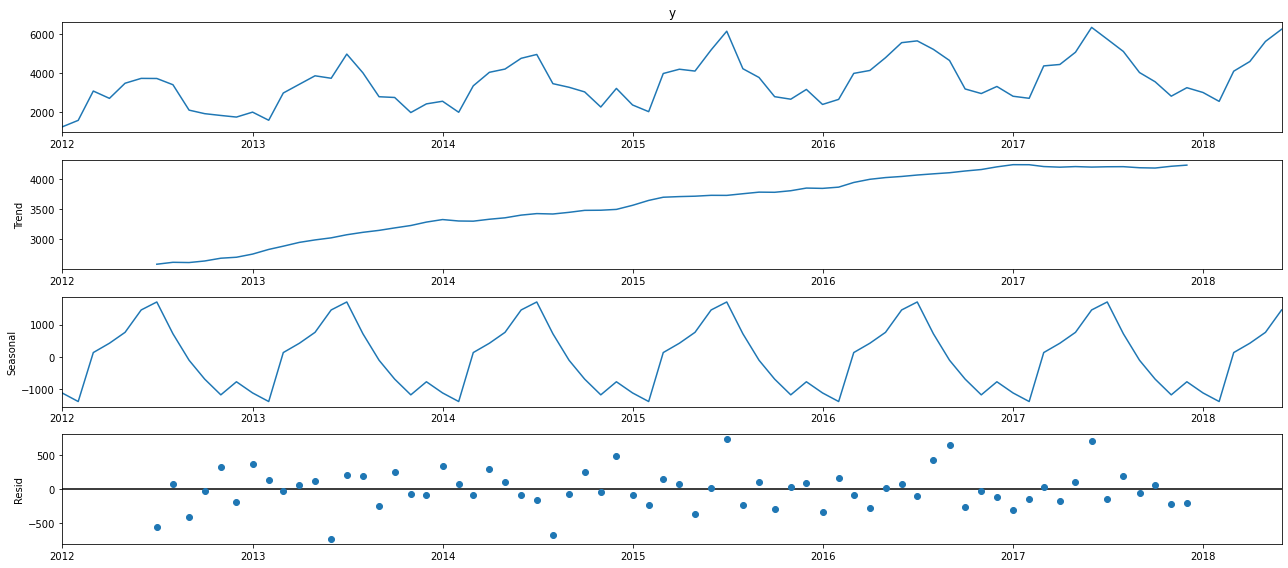

In [53]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

From the plot above we can clearly see the seasonal component of the data, and we can also see the separated upward trend of sales in time.

# Stationarity Test
****

Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

* Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

* Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [54]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [55]:
total_sales_daily_sum

,date_x,y
0,2012-01-01,95893.036745
1,2012-02-01,118535.750612
2,2012-03-01,234472.645893
3,2012-04-01,205492.234465
4,2012-05-01,268655.142392
...,...,...
73,2018-02-01,297729.358282
74,2018-03-01,488924.897841
75,2018-04-01,548104.851969
76,2018-05-01,670852.115058


In [56]:
test_stationarity(total_sales_daily_sum["y"])

Results of Dickey-Fuller Test:
Test Statistic                 -4.304432
p-value                         0.000436
#Lags Used                     11.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


p-value lower than 1% shows that the data probably isn't stationary.

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4 is less than the value of -3.533 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

# Feature Scaling
****

Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

Since we trained tree-based models on the data, feature scaling isn't needed.

# Transformations on the test set

Making the same transformations on the test set as on the training set:

In [57]:
X_test = X_test.drop(to_drop, axis = 1)

In [58]:
X_test.drop(['x5', 'x6', 'x11', 'x17', 'x18', 'x25', 'x32', 'x39', 'x46', 'x53', 'x60', 'x67', 'x74', 'x81', 'x95', 'x102' ], axis = 1, inplace=True)

for column in X_test.iloc[:,2:].columns:
    fill_na(column)
    
for column in X_test.iloc[:,2:].columns:
    transform_columns_flooring_capping(X_test, column)
    
X_test['date'] = pd.to_datetime(X_test['date'])

X_test["month"] = pd.DatetimeIndex(X_test["date"]).month
X_test["year"] = pd.DatetimeIndex(X_test["date"]).year

X_test.infer_objects()

len(X_test.columns)

dataset = dataset.drop(["date_y"] ,axis = 1)
X_test = X_test.drop("date", axis = 1)

Skewness of column x1 BEFORE the flooring and capping: 10.15
Skewness of column x1 AFTER the flooring and capping: 1.97

Skewness of column x2 BEFORE the flooring and capping: 16.30
Skewness of column x2 AFTER the flooring and capping: 2.11

Skewness of column x3 BEFORE the flooring and capping: 11.93
Skewness of column x3 AFTER the flooring and capping: 2.04

Skewness of column x4 BEFORE the flooring and capping: 13.97
Skewness of column x4 AFTER the flooring and capping: 1.98

Skewness of column x7 BEFORE the flooring and capping: 5.00
Skewness of column x7 AFTER the flooring and capping: 1.74

Skewness of column x8 BEFORE the flooring and capping: 5.33
Skewness of column x8 AFTER the flooring and capping: 1.86

Skewness of column x10 BEFORE the flooring and capping: 3.74
Skewness of column x10 AFTER the flooring and capping: 1.72

Skewness of column x12 BEFORE the flooring and capping: 10.55
Skewness of column x12 AFTER the flooring and capping: 1.64

Skewness of column x14 BEFORE t

# Feature Importance
****

Tree-based estimators can be used to compute impurity-based feature importances, which in turn can be used to discard irrelevant features (when coupled with the SelectFromModel meta-transformer):

In [59]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(dataset.iloc[:,:-1], dataset.iloc[:,-1])

RandomForestRegressor()

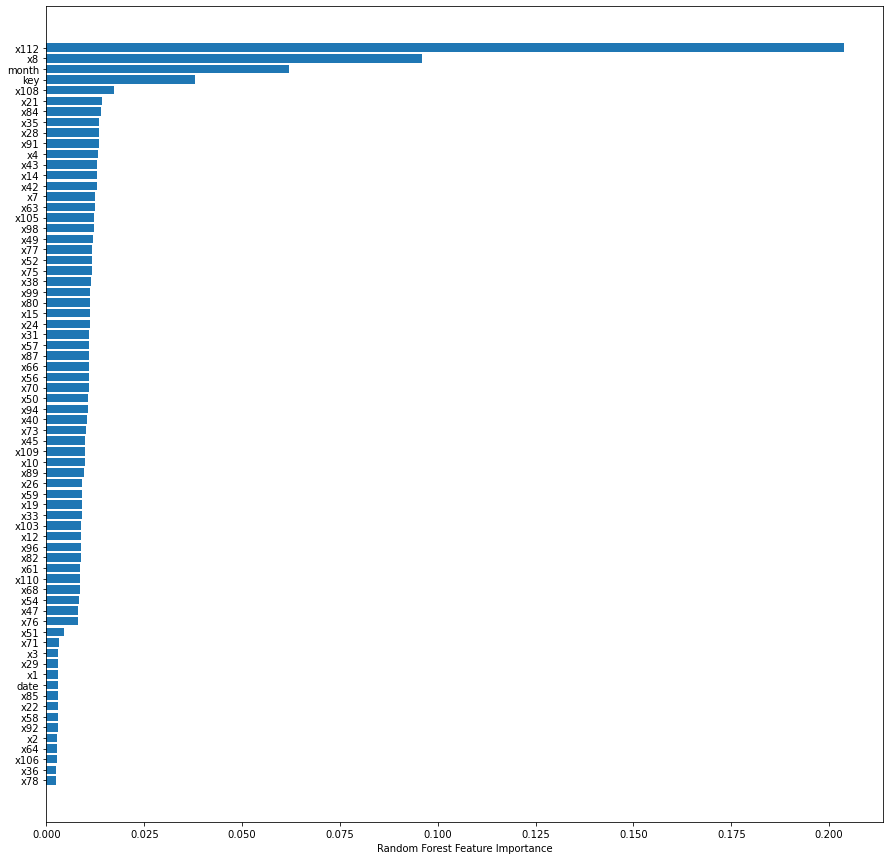

In [60]:
sorted_idx = rf.feature_importances_.argsort()

plt.figure(figsize=(15,15))
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

In [61]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(rf, prefit=True)
#X_new = model.transform(X_train)

It is visible that the most important features are key, year, month, x10, x109 and x22. We will make predictions on these variables.

# Creating the Models
****

This problem is Multi Variate Time Series Forecasting

Since we don't have the actual y_test values to be predicted, but an empty column, we will take a part of the dataset for validation and check the model on the validation dataset

In [62]:
from sklearn.model_selection import train_test_split

dataset, validation_set = train_test_split(dataset, train_size = 0.8, shuffle = False)

Sets for predictions:

In [63]:
validation_set_features = validation_set[["key", "year", "month", "x10", "x22", "x85", "x92", "x109"]]
validation_set_y = validation_set.iloc[:,-1]

In [64]:
dataset_features = dataset.iloc[:,:-1]
dataset_features = dataset_features[["key", "year", "month", "x10", "x22", "x85", "x92", "x109"]]
y_test = dataset.iloc[:,-1]

wmape = sum(np.abs(actual - forecast))/sum(actual)

In [65]:
def WMAPE (forecast, actual):
    wmape = 0
    sum_j = 0
    sum_abs = 0
    for i,j in zip(forecast, actual):
        sum_abs += np.abs(i - j)
        sum_j += j 
    wmape = sum_abs/sum_j
    print(round(wmape,2))
    print('WMAPE Score: ', str(round(wmape * 100, 2)) , ' %')

In [66]:
from xgboost import XGBRegressor
from xgboost import plot_importance

def xboost(x_train, y_train, x_test):
    dtrain = xgb.DMatrix(x_train, label = y_train, feature_names = list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names = list(x_test.columns))

    params = {'max_depth':10,
              'eta':0.2,
              'silent':1,
              'subsample':1}
    
    num_rounds = 4000

    bst = xgb.train(params, dtrain, num_rounds)
    plot_importance(bst)
    
    return pd.Series(bst.predict(dtest))

[20:07:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




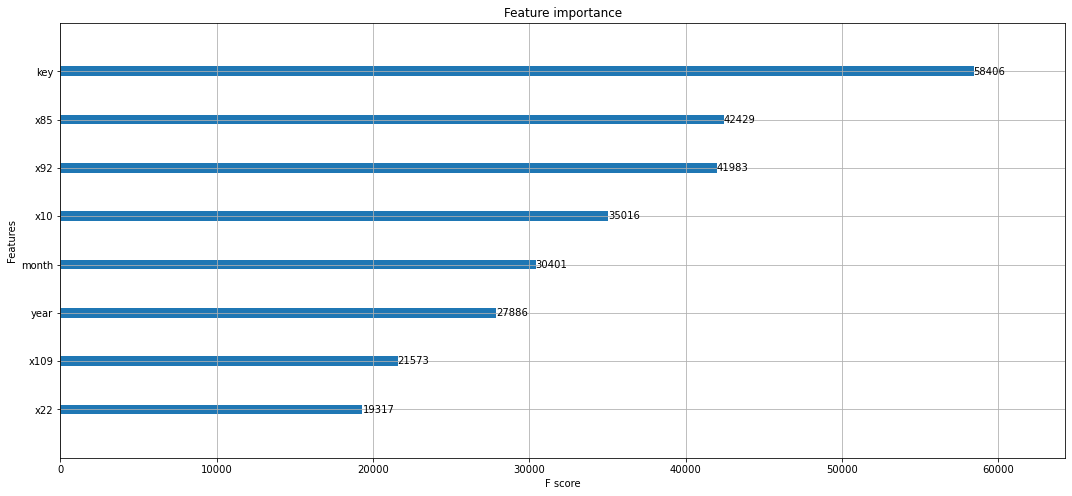

In [67]:
predictions_validation = xboost(dataset_features, y_test, validation_set_features)

In [68]:
WMAPE(predictions_validation, validation_set_y)

0.47
WMAPE Score:  46.94  %


## LightGBM Model
****

XGBoost applies level-wise tree growth where LightGBM applies leaf-wise tree growth. Level-wise approach grows horizontal whereas leaf-wise grows vertical.

In [69]:
lgb_params =  { 'metric': 'mae',
                'num_leaves' : 12,
                'max_depth': 10,
                'min_child_samples': 5,
                'learning_rate': 0.03,
                'colsample_bytree': 0.5,
                'verbose': 0,
                'num_boost_round': 2000,
                'early_stopping_rounds': 200,
                'min_child_weight' : 0.1,
                'nthread': -1}

cols = [col for col in dataset_features.columns]

In [70]:
lgbtrain = lgb.Dataset(data = dataset_features, label = y_test, feature_name = cols)

lgbval = lgb.Dataset(data = validation_set_features, 
                     label = validation_set_y, 
                     reference = lgbtrain, 
                     feature_name = cols)

model_lgb = lgb.train(lgb_params, 
                  lgbtrain,
                  valid_sets = [lgbtrain, lgbval],
                  num_boost_round = lgb_params['num_boost_round'],
                  early_stopping_rounds = lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002307 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's l1: 1408.79	valid_1's l1: 1518.93
[200]	training's l1: 1276.39	valid_1's l1: 1482.34
[300]	training's l1: 1199.2	valid_1's l1: 1473.56
[400]	training's l1: 1146	valid_1's l1: 1477.88
[500]	training's l1: 1102.98	valid_1's l1: 1491.21
Early stopping, best iteration is:
[303]	training's l1: 1196.71	valid_1's l1: 1473.26


In [71]:
y_pred_val = model_lgb.predict(validation_set_features, num_iteration = model_lgb.best_iteration)

In [72]:
WMAPE(y_pred_val, validation_set_y)

0.4
WMAPE Score:  39.7  %


## CatBoost
****

In [73]:
from catboost import CatBoostRegressor

In [74]:
model_cb = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)

In [75]:
model_cb.fit(dataset_features, y_test)

predictions_cb = model_cb.predict(validation_set_features)

0:	learn: 2067.5306282	total: 53ms	remaining: 53ms
1:	learn: 1964.0145043	total: 54.8ms	remaining: 0us


In [76]:
WMAPE(predictions_cb, validation_set_y)

0.42
WMAPE Score:  41.97  %


# Conclusion
****

LightGBM model showed the best results when testing on the validation_set, with 39.7%. Next, we will change the hyperparameters to get the best values and to lower the WMAPE measure of error:

In [77]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
    'num_leaves' : [10, 12, 14],
    'max_depth': [8, 10, 12],
    'min_child_samples': [4, 5],
    'learning_rate': [0.03],
    'colsample_bytree': [0.4, 0.5],
    'verbose': [0, 1],
    'num_boost_round': [2500],
    'early_stopping_rounds': [300],
    'min_child_weight' : [0.1, 0.2],
    'nthread': [-1]
    }
    ]

In [78]:
model_lgb_1 = lgb.LGBMRegressor()

gs = GridSearchCV(
    estimator=model_lgb_1,
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error',
    verbose=2
)

In [79]:
lgb_params =  { 'metric': 'mae',
                'num_leaves' : 12,
                'max_depth': 10,
                'min_child_samples': 14,
                'learning_rate': 0.03,
                'colsample_bytree': 0.5,
                'verbose': 0,
                'num_boost_round': 2000,
                'early_stopping_rounds': 200,
                'min_child_weight' : 0.1,
                'nthread': -1}

lgbtrain = lgb.Dataset(data = dataset_features, label = y_test, feature_name = cols)

lgbval = lgb.Dataset(data = validation_set_features, 
                     label = validation_set_y, 
                     reference = lgbtrain, 
                     feature_name = cols)

model_lgb = lgb.train(lgb_params, 
                  lgbtrain,
                  valid_sets = [lgbtrain, lgbval],
                  num_boost_round = lgb_params['num_boost_round'],
                  early_stopping_rounds = lgb_params['early_stopping_rounds'],
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002220 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 1409.16	valid_1's l1: 1519.27
[200]	training's l1: 1279.67	valid_1's l1: 1479.26
[300]	training's l1: 1205.08	valid_1's l1: 1472.18
[400]	training's l1: 1149.15	valid_1's l1: 1475.38
Early stopping, best iteration is:
[291]	training's l1: 1210.68	valid_1's l1: 1471.19


In [80]:
y_pred_val = model_lgb.predict(validation_set_features, num_iteration = model_lgb.best_iteration)

In [81]:
WMAPE(y_pred_val, validation_set_y)

0.4
WMAPE Score:  39.65  %


# Predictions on the Test Set
****

After taking only the most important features, using the best performing model on the validation set to predict test set results:

In [82]:
X_test_features = X_test[["key", "year", "month", "x10", "x22", "x85", "x92", "x109"]]

In [83]:
y_test = model_lgb.predict(X_test_features, num_iteration = model_lgb.best_iteration)

In [84]:
y_test = pd.DataFrame(y_test, columns = ["y"])

In [97]:
X_test

,key,x1,x2,x3,x4,x7,x8,x10,x12,x14,...,x103,x105,x106,x108,x109,x110,x112,month,year,id
0,683,0.000000,0.000000,0.397238,0.0000,119.936184,114.063630,6024.457359,0.462340,6.499243,...,0.019900,0.000000,2206.040376,0.000000,39.599762,7.289597,27.328970,7,2018,0
1,683,NaN,0.000000,0.000000,0.0000,593.803092,NaN,6024.457359,NaN,NaN,...,0.000000,0.141846,130.027455,0.357027,33.098055,17.244210,3.189301,8,2018,1
2,683,0.000000,0.000000,0.000000,0.0000,222.106715,7.926074,3678.029954,1.158072,0.000000,...,88.110086,1.003184,NaN,NaN,8.638553,NaN,NaN,9,2018,2
3,683,0.607430,0.576041,0.000000,0.0000,59.588630,361.870894,5274.149878,2.838254,2.142438,...,6.852297,38.906611,102.735687,0.000000,14.646718,2.719439,0.267833,10,2018,3
4,683,0.000000,0.000000,0.000000,0.6485,1970.406869,6.444104,4552.412721,0.102331,0.000000,...,10.802692,1.605068,71.384402,0.000000,0.000000,2.190175,0.833723,11,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,99444,0.167286,0.000000,0.000000,0.0000,28.683344,671.811450,6024.457359,8.320817,28.992993,...,1.841767,38.906611,53.162367,0.000000,52.082725,0.764603,0.262702,2,2019,1423
1424,99444,0.000000,0.000000,0.000000,0.6485,114.679868,6.508677,6024.457359,0.000000,0.000000,...,0.000000,0.000000,11.386100,0.000000,142.196722,0.356890,0.000000,3,2019,1424
1425,99444,0.317642,0.000000,0.000000,NaN,2674.140175,575.320377,6024.457359,80.750194,0.000000,...,0.000000,0.284562,2.814448,0.000000,165.414227,0.038380,0.073461,4,2019,1425
1426,99444,0.000000,0.000000,0.598422,0.0000,677.526635,8.384144,6024.457359,0.629653,0.000000,...,7.098375,13.501808,28.990518,0.026931,58.296873,3.361134,0.000000,5,2019,1426


In [96]:
X_test['id'] = np.arange(len(X_test))

In [93]:
y_test['id'] = np.arange(len(y_test))

combine x_test and y_test into y_test, and concat only 01 + month + year, and key and y prediction

In [102]:
y_test = pd.merge(y_test, X_test, left_on = "id", right_on = "id")

In [167]:
months = y_test['month'].astype(int)
month_abbr = []
date = []

for month in months:
    abbr = calendar.month_abbr[month]
    month_abbr.append(abbr)

for abbr in month_abbr:
    date.append("01" + abbr)
    
y_test['date'] = date + y_test['year'].astype(str)

In [171]:
y_test = y_test[["key", "date", "y"]]

In [172]:
y_test

,key,date,y
0,683,01Jul2018,5080.077683
1,683,01Aug2018,4286.903518
2,683,01Sep2018,3613.895160
3,683,01Oct2018,2900.301780
4,683,01Nov2018,2437.221981
...,...,...,...
1423,99444,01Feb2019,3026.742473
1424,99444,01Mar2019,4804.224906
1425,99444,01Apr2019,5141.778987
1426,99444,01May2019,5849.527317


In [173]:
y_test.to_csv("y_test.csv")